In [3]:
import os
import torch
import pandas as pd
import numpy as np
import torchvision
import torch.nn as nn
import cv2
from matplotlib import pyplot as plt
import PIL
from enum import Enum
from numpy import linalg as LA
from shapely.geometry import Polygon
from google.colab.patches import cv2_imshow
%matplotlib inline

In [4]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
hallway_images = '/content/drive/My Drive/Colab Notebooks/hallway_images'

Mounted at /content/drive


Question 4

In [143]:
img1 = cv2.imread(hallway_images + '/hallway1.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.imread(hallway_images + '/hallway2.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.imread(hallway_images + '/hallway3.jpg')
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

def get_gray(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    res = np.zeros_like(img)
    res[:,:,0] = gray
    res[:,:,1] = gray
    res[:,:,2] = gray
    return res

gray1 = get_gray(img1)
gray2 = get_gray(img2)
gray3 = get_gray(img3)

In [21]:
class Q4Case(Enum):
    A = 'Case A'
    B = 'Case B'
    C = 'Case C'

4.1

In [250]:
A_pts_src = np.array([[821, 645], [950, 263], [886, 231], [926, 141], [1097, 230]])
A_pts_dst = np.array([[700, 967], [807, 577], [742, 548], [777, 458], [948, 539]])

B_pts_src = np.array([[723, 550], [785, 585], [999, 82], [997, 804], [740, 375]])
B_pts_dst = np.array([[752, 745], [790, 775], [902, 273], [922, 981], [762, 567]])

C_pts_src = np.array([[995, 822], [500, 750], [730, 552], [820, 647], [660, 548]])
C_pts_dst = np.array([[920, 999], [448, 948], [757, 744], [816, 843], [695, 740]])

In [116]:
def plot_pts(img, pts, color='yellow'):
    rgb = (0, 0, 0)
    if color == 'yellow':
        rgb = (255, 255, 0)
    elif color == 'red':
        rgb = (255, 0, 0)
    elif color == 'green':
        rgb = (0, 255, 0)
    else:
        rgb = (255, 255, 0)
    for x, y in pts:
        cv2.rectangle(img, (x-15, y-15), (x+15, y+15), (rgb[0], rgb[1], rgb[2]), 2)

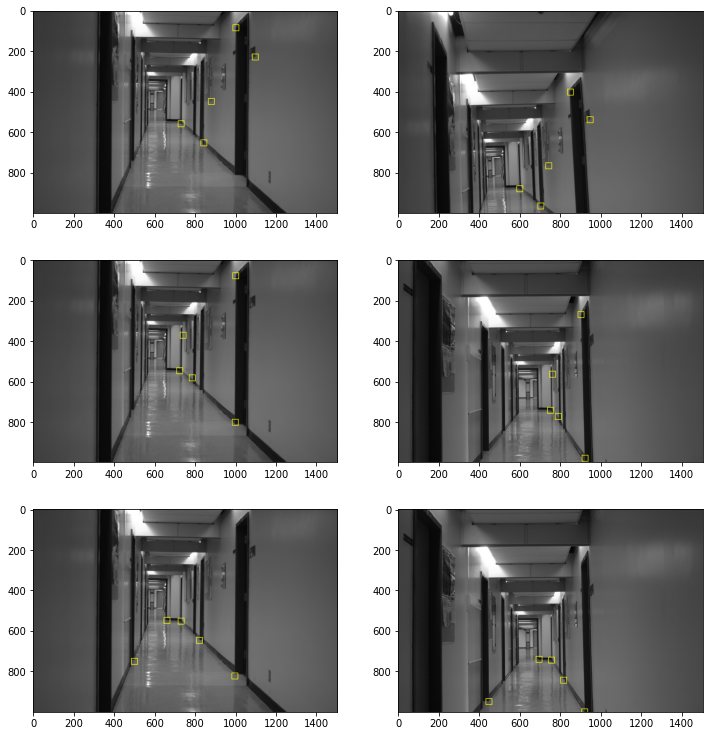

In [117]:
# Case A
A_gray1 = gray1.copy()
plot_pts(A_gray1, A_pts_src)
A_gray2 = gray2.copy()
plot_pts(A_gray2, A_pts_dst)
# Case B
B_gray1 = gray1.copy()
plot_pts(B_gray1, B_pts_src)
B_gray3 = gray3.copy()
plot_pts(B_gray3, B_pts_dst)
# Case C
C_gray1 = gray1.copy()
plot_pts(C_gray1, C_pts_src)
C_gray3 = gray3.copy()
plot_pts(C_gray3, C_pts_dst)
# plot
fig, axes = plt.subplots(3, 2, figsize=(12, 13))
axes[0][0].imshow(A_gray1)
axes[0][1].imshow(A_gray2)
axes[1][0].imshow(B_gray1)
axes[1][1].imshow(B_gray3)
axes[2][0].imshow(C_gray1)
axes[2][1].imshow(C_gray3)

4.2

In [177]:
def homography_matrix(pts_src, pts_dst):
    length = len(pts_src)
    A = np.zeros((2*length, 9))
    for i in range(pts_src.shape[0]):
        A[2*i] = [pts_src[i][0], pts_src[i][1], 1, 0, 0, 0, -pts_dst[i][0]*pts_src[i][0], -pts_dst[i][0]*pts_src[i][1], -pts_dst[i][0]]
        A[2*i+1] = [0, 0, 0, pts_src[i][0], pts_src[i][1], 1, -pts_dst[i][1]*pts_src[i][0], -pts_dst[i][1]*pts_src[i][1], -pts_dst[i][1]]

    u, s, vh = np.linalg.svd(A)
    res = (vh[-1,:] / vh[-1,-1]).reshape((3,3))
    res_check, _ = cv2.findHomography(pts_src, pts_dst)
    return res_check

In [251]:
h_A = homography_matrix(A_pts_src, A_pts_dst)
print('Case A Homography H:')
print(h_A)
print()
h_B = homography_matrix(B_pts_src, B_pts_dst)
print('Case B Homography H:')
print(h_B)
print()
h_C = homography_matrix(C_pts_src, C_pts_dst)
print('Case C Homography H:')
print(h_C)
print()

Case A Homography H:
[[ 1.11893182e+00  3.65668141e-02 -2.08250298e+02]
 [ 4.06281751e-03  1.03827330e+00  3.41011423e+02]
 [ 8.28982954e-05 -3.00880181e-05  1.00000000e+00]]

Case B Homography H:
[[ 6.40828578e-01 -1.19466574e-01  3.29354146e+02]
 [-6.01852113e-02  8.83064922e-01  2.78186098e+02]
 [ 7.73752312e-05 -1.63061684e-04  1.00000000e+00]]

Case C Homography H:
[[ 1.87598459e+00 -5.52203039e-01  7.07182942e+00]
 [ 6.82422020e-01  1.13430165e+00 -6.87381704e+01]
 [ 7.64011873e-04 -2.63450129e-04  1.00000000e+00]]



4.3

In [179]:
def estimated_point(h, pt):
    x, y = pt
    v = np.array([x, y, 1.])
    v = h @ v
    z = v[2]
    v = v / z
    est_x, est_y = round(v[0]), round(v[1])
    return est_x, est_y


def estimated_points(h, pts):
    estimated = []
    for pt in pts:
        est_x, est_y = estimated_point(h, pt)
        estimated.append([est_x, est_y])
    return estimated

In [175]:
def plot_q3(img, case = Q4Case.A):
    img_copy = img.copy()
    if case == Q4Case.A:
        pts_src = A_pts_src
        pts_dst = A_pts_dst
    elif case == Q4Case.B:
        pts_src = B_pts_src
        pts_dst = B_pts_dst
    else:
        pts_src = C_pts_src
        pts_dst = C_pts_dst
    h = homography_matrix(pts_src, pts_dst)
    pts_est = estimated_points(h, pts_src)
    plot_pts(img_copy, pts_dst, 'red')
    plot_pts(img_copy, pts_est, 'green')
    return img_copy

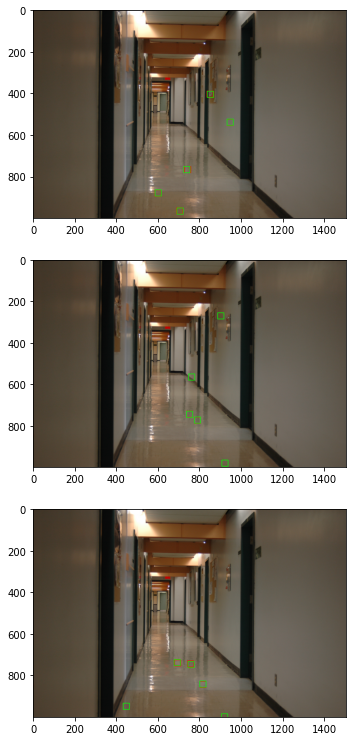

In [180]:
# Case A
A_img1 = plot_q3(img1, Q4Case.A)
# Case B
B_img1 = plot_q3(img1, Q4Case.B)
# Case C
C_img1 = plot_q3(img1, Q4Case.C)
# plot
fig, axes = plt.subplots(3, 1, figsize=(12, 13))
axes[0].imshow(A_img1)
axes[1].imshow(B_img1)
axes[2].imshow(C_img1)

4.4

In [265]:
def run_q4(case = Q4Case.A):
    gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    gray1 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    if case == Q4Case.A:
        h = h_A
    elif case == Q4Case.B:
        h = h_B
    else:
        h = h_C

    pad = 500
    def in_domain(x, y, padx, pady):
        return 0 <= x < padx and 0 <= y < pady
    m, n = 2 * gray1.shape[0], 2 * gray1.shape[1]
    new_img = np.zeros((m, n, 3))
    pts = []
    for x in range(-pad, m-pad):
        for y in range(-pad, n-pad):
            pts.append([x, y])
    pts = estimated_points(h, pts)
    new_img[pad:pad+gray1.shape[0], pad:pad+gray1.shape[1], 0] = gray1

    i = 0
    for pt in pts:
        x, y = pt
        new_x, new_y = i // m, i % m
        if in_domain(x, y, gray2.shape[1], gray2.shape[0]):
            new_img[new_x, new_y, 1] = gray2[y, x]
            new_img[new_x, new_y, 2] = gray2[y, x]
        i += 1

    plt.imshow(new_img)

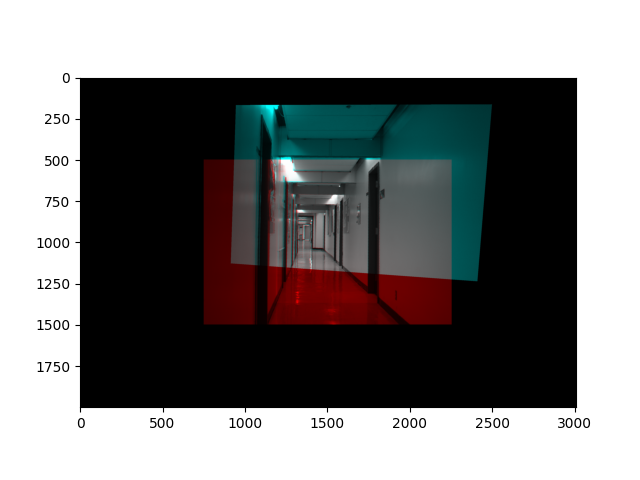

In [264]:
run_q4(Q4Case.A)

In [ ]:
run_q4(Q4Case.B)

In [ ]:
run_q4(Q4Case.C)

Question 5

5.1

In [34]:
def get_iou(box1, box2):
    x1, y1, x11, y11 = box1
    x2, y2, x22, y22 = box2

    x_ul = max(x1, x2)
    y_ul = max(y1, y2)
    x_lr = min(x11, x22)
    y_lr = min(y11, y22)
    area_of_overlap = max(0, x_lr - x_ul) * max(0, y_lr - y_ul)
    area_of_union = (x11 - x1) * (y11 - y1) + (x22 - x2) * (y22 - y2) - area_of_overlap  # double count
    iou = area_of_overlap / area_of_union
    return iou

In [39]:
q5_video_root = '/content/drive/My Drive/Colab Notebooks/KylianMbappe.mp4'
cap = cv2.VideoCapture(q5_video_root) # video
# capture one frame
ret,frame = cap.read()

# detect a face on the first frame
face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml') 
face_boxes = face_detector.detectMultiScale(frame) 

if len(face_boxes)==0:
    print('no face detected')
    assert(False)

# initialize the tracing window around the (first) detected face
(x,y,w,h) = tuple(face_boxes[0]) 
track_window = (x,y,w,h)

#  region of interest for tracking
roi = frame[y:y+h, x:x+w]

# convert the roi to HSV so we can construct a histogram of Hue 
hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

# why do we need this mask? (remember the cone?)
# read the description for Figure 3 in the original Cam Shift paper: http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.14.7673 
mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))


# form histogram of hue in the roi
roi_hist = cv2.calcHist([hsv_roi],[0],mask,[180],[0,180])

# normalize the histogram array values so they are in the min=0 to max=255 range
cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)

# termination criteria for mean shift: 10 iteration or shift less than 1 pixel
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

ious = []
frames = []
while True:
    
    # grab a frame
    ret ,frame = cap.read() 
    
    if ret == True: 
  
        # convert to HSV
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        
        # histogram back projection using roi_hist 
        dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)
        
        # use meanshift to shift the tracking window
        ret, track_window = cv2.meanShift(dst, track_window, term_crit)
        
        # display tracked window
        x1,y1,w1,h1 = track_window
        img1 = cv2.rectangle(frame, (x1,y1), (x1+w1,y1+h1), (0,0,255),5)
        box1 = [x1,y1,x1+w1,y1+h1]

        # detector
        face_boxes = face_detector.detectMultiScale(frame)
        if len(face_boxes) == 0:
            iou = 0
        else:
            x2,y2,w2,h2 = 0, 0, 0, 0
            max_iou = -1
            for face_box in face_boxes:
                tx2,ty2,tw2,th2 = face_box
                box2 = [tx2,ty2,tx2+tw2,ty2+th2]
                iou = get_iou(box1, box2)
                if iou > max_iou:
                    max_iou = iou
                    x2,y2,w2,h2 = tx2,ty2,tw2,th2
            iou = max_iou
            img2 = cv2.rectangle(frame, (x2,y2), (x2+w2,y2+h2), (0,255,0),5)
        ious.append(iou)
        frames.append(frame)
        
        # cv2_imshow(img)
        
        if cv2.waitKey(33) & 0xFF == 27: # wait a bit and exit is ESC is pressed
            break
        
    else:
        break
        
cv2.destroyAllWindows()
cap.release()

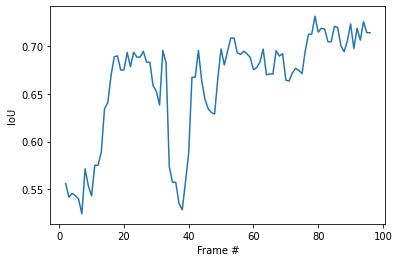

In [40]:
frame_count = [i for i in range(2, len(ious)+1)]
plt.plot(frame_count, ious[1:])
plt.xlabel("Frame #")
plt.ylabel("IoU")
plt.show()

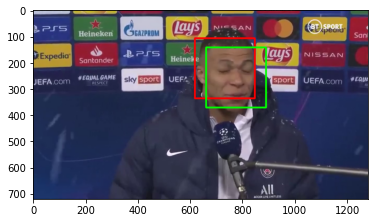

In [43]:
low_iou_index = ious.index(min(ious))
plt.imshow(cv2.cvtColor(frames[low_iou_index], cv2.COLOR_BGR2RGB))

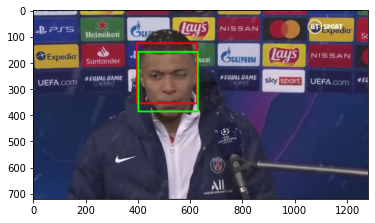

In [44]:
high_iou_index = ious.index(max(ious))
plt.imshow(cv2.cvtColor(frames[high_iou_index], cv2.COLOR_BGR2RGB))

In [49]:
large_iou_counter = 0
for iou in ious:
    if iou > 0.5:
        large_iou_counter += 1
large_iou_percentage = large_iou_counter / len(ious) * 100
print(str(large_iou_percentage) + '%')

100.0%


5.2

In [89]:
q5_video_root = '/content/drive/My Drive/Colab Notebooks/KylianMbappe.mp4'
cap = cv2.VideoCapture(q5_video_root) # video
# capture one frame
ret,frame = cap.read()

# detect a face on the first frame
face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml') 
face_boxes = face_detector.detectMultiScale(frame) 

if len(face_boxes)==0:
    print('no face detected')
    assert(False)

# initialize the tracing window around the (first) detected face
(x,y,w,h) = tuple(face_boxes[0]) 
track_window = (x,y,w,h)

#  region of interest for tracking
roi = frame[y:y+h, x:x+w]

# gray_roi: mag, angle
gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
Ix = cv2.Sobel(gray_roi, cv2.CV_32F, 1, 0)
Iy = cv2.Sobel(gray_roi, cv2.CV_32F, 0, 1)

mag, angle = cv2.cartToPolar(Ix, Iy, angleInDegrees=True)
angle = np.array([angle], dtype=np.uint16)

mask = cv2.inRange(mag, np.max(mag) / 20.0, float(np.max(mag)))

# form histogram of hue in the roi
roi_hist = cv2.calcHist(angle,[0],mask,[24],[0,360])

# normalize the histogram array values so they are in the min=0 to max=255 range
cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)

# termination criteria for mean shift: 10 iteration or shift less than 1 pixel
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

ious = []
frames = []
while True:
    
    # grab a frame
    ret ,frame = cap.read() 
    
    if ret == True: 
  
        # convert to GRAY
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        Ix = cv2.Sobel(gray, cv2.CV_32F, 1, 0)
        Iy = cv2.Sobel(gray, cv2.CV_32F, 0, 1)

        mag, angle = cv2.cartToPolar(Ix, Iy, angleInDegrees=True)
        angle = np.array([angle], dtype=np.uint16)
        
        # histogram back projection using roi_hist 
        dst = cv2.calcBackProject(angle,[0],roi_hist,[0,360],1)
        
        # use meanshift to shift the tracking window
        ret, track_window = cv2.meanShift(dst, track_window, term_crit)
        
        # display tracked window
        x1,y1,w1,h1 = track_window
        img1 = cv2.rectangle(frame, (x1,y1), (x1+w1,y1+h1), (0,0,255),5)
        box1 = [x1,y1,x1+w1,y1+h1]

        # detector
        face_boxes = face_detector.detectMultiScale(frame)
        if len(face_boxes) == 0:
            iou = 0
        else:
            x2,y2,w2,h2 = 0, 0, 0, 0
            max_iou = -1
            for face_box in face_boxes:
                tx2,ty2,tw2,th2 = face_box
                box2 = [tx2,ty2,tx2+tw2,ty2+th2]
                iou = get_iou(box1, box2)
                if iou > max_iou:
                    max_iou = iou
                    x2,y2,w2,h2 = tx2,ty2,tw2,th2
            iou = max_iou
            img2 = cv2.rectangle(frame, (x2,y2), (x2+w2,y2+h2), (0,255,0),5)
        ious.append(iou)
        frames.append(frame)
        
        # cv2_imshow(img)
        
        if cv2.waitKey(33) & 0xFF == 27: # wait a bit and exit is ESC is pressed
            break
        
    else:
        break
        
cv2.destroyAllWindows()
cap.release()

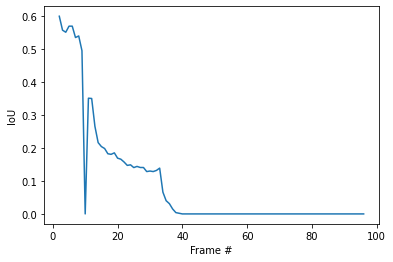

In [90]:
frame_count = [i for i in range(2, len(ious)+1)]
plt.plot(frame_count, ious[1:])
plt.xlabel("Frame #")
plt.ylabel("IoU")
plt.show()

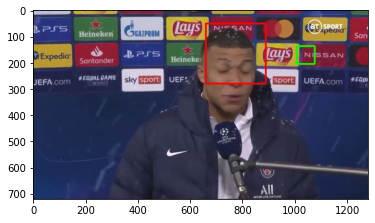

In [91]:
low_iou_index = ious.index(min(ious))
plt.imshow(cv2.cvtColor(frames[low_iou_index], cv2.COLOR_BGR2RGB))

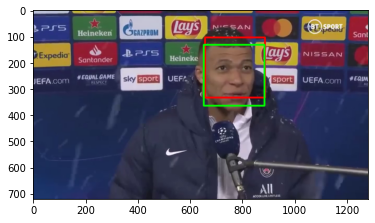

In [92]:
high_iou_index = ious.index(max(ious))
plt.imshow(cv2.cvtColor(frames[high_iou_index], cv2.COLOR_BGR2RGB))

In [93]:
large_iou_counter = 0
for iou in ious:
    if iou > 0.5:
        large_iou_counter += 1
large_iou_percentage = large_iou_counter / len(ious) * 100
print(str(large_iou_percentage) + '%')

8.333333333333332%
